In [1]:
import datetime
import json
import math
import numpy as np
import os
import sys
import time
import re
from typing import Iterable
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

from dataset.util import GaussianBlur, DownSampleAndUpsample
from models.losses import MultiPosConLoss
from models.StableRep import model_dict as v_model_dict
from torch.utils.data import Dataset

import util.misc as misc
from util.misc import NativeScalerWithGradNormCount as NativeScaler

In [2]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
device = torch.device("cuda:0")
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

if cuda_available:
    # Get the CUDA device count
    cuda_device_count = torch.cuda.device_count()
    print("CUDA device count:", cuda_device_count)

    # Get the current CUDA device index
    current_cuda_device = torch.cuda.current_device()
    print("Current CUDA device index:", current_cuda_device)

    # Get the name of the current CUDA device
    current_cuda_device_name = torch.cuda.get_device_name(current_cuda_device)
    print("Current CUDA device name:", current_cuda_device_name)

    # Get the CUDA device properties
    cuda_device_properties = torch.cuda.get_device_properties(current_cuda_device)
    print("CUDA device properties:")
    print("   Name:", cuda_device_properties.name)
    print("   CUDA capability:", cuda_device_properties.major, ".", cuda_device_properties.minor)
    print("   Total memory:", round(cuda_device_properties.total_memory / (1024 ** 3), 1), "GB")

PyTorch version: 1.12.0
CUDA available: True
CUDA device count: 1
Current CUDA device index: 0
Current CUDA device name: NVIDIA GeForce RTX 3080
CUDA device properties:
   Name: NVIDIA GeForce RTX 3080
   CUDA capability: 8 . 6
   Total memory: 10.0 GB


In [3]:
args = {
    # Training parameters
    'epochs': 15,

    # Model parameters
    'model': 'base',
    'add_language': False,
    'tokenizer': 'CLIP',

    # Self-supervised learning parameters
    'ssl_mlp_dim': 4096,
    'ssl_emb_dim': 256,
    'ssl_scale': 1.0,
    'ssl_temp': 0.1,
    'ssl_temp_cos': False,
    'ssl_temp_min': 0.05,
    'ssl_temp_max': 0.1,
    'ssl_w1': 1.0,
    'ssl_w2': 1.0,
    'vl_projection': 'linear',

    # Optimizer parameters
    'weight_decay': 0.1,
    'lr': None,
    'beta1': 0.9,
    'beta2': 0.95,
    'blr': 1e-3,
    'min_lr': 0.0,
    'warmup_epochs': 1.0,

    # Output and logging parameters
    'output_dir': './output_dir/out',
    'log_dir': './output_dir/log',
    'device': 'cuda',
    'seed': 0,
    'resume': '',
    'start_epoch': 0,
    'num_workers': 8,
    'pin_mem': True,
    'print_freq': 100,
    'save_freq': 5,
    'n_keep': 3,

    # Dataset parameters
    'root_folder': './SSL_embeddings',
    'n_img': 3,
    'num_crop': 1,
    'batch_size': 4,
    'weak_aug': False,

    # Downsample augmentation parameters
    'downsample': False,
    'downsample_prob': 0.05,
    'down_res': None,
    'down_prob': None
}

In [4]:
class DictToObject:
    def __init__(self, d):
        for key, value in d.items():
            setattr(self, key, value)
args = DictToObject(args)

In [5]:
class SSLGenDataset(Dataset):
    def __init__(self, root_folder, transforms, num_views=1,
                 root_list=None, num_crop=1, tokenizer=None):
        # logging.debug(f'Loading csv data from {input_filename}.')
        print(f'Loading data from {root_folder}.')
        self.images = []
        self.num_views = num_views
        self.class_names = []
        self.real_folder_path = os.path.join(root_folder, "Real")
        self.syn_folder_path = os.path.join(root_folder, "Synthetic")
        for folder_name in os.listdir(self.syn_folder_path):
            folder_path = os.path.join(self.syn_folder_path, folder_name)
            if os.path.isdir(folder_path):
                self.class_names.append(folder_name)
        for each_class in self.class_names:
            folder_path = os.path.join(self.syn_folder_path, each_class)
            for img_path in os.listdir(folder_path):
                self.images.append(img_path)
        # references_set = set(item[:9] for item in self.images)
        # List to store extracted references
        self.references = set()
        
        # Iterate over each item in the data list
        for item in self.images:
            # print(item)
            pattern = r'(.+?)_\d+\.png'
            matches = re.search(pattern, item)
            if matches:
                match = matches.group(1)
            else:
                print ('file format is broken:', item)
            # print(matches)
            # break
            if match:
                self.references.add(match)

        self.references = list(self.references)
        self.transforms = transforms
        print('Done loading data.')

    def __len__(self):
        return len(self.references)

    def __getitem__(self, idx):
        # sample num_view of images and transform them
        images = []
        pattern = r'^([^_]+)'
        img_prefix = self.references[idx]
        # print(img_prefix)
        matches = re.search(pattern, img_prefix)
        if matches:
            class_name = matches.group(1)
        
        else:
            print("No match found")
        for i in range(self.num_views):
            image_path = os.path.join(self.syn_folder_path, f"{class_name}/{img_prefix}_{i}.png")
            image = Image.open(image_path).convert('RGB')
            # plt.imshow(image)
            # plt.axis('off')  # Optional: Turn off axis
            # plt.show()
            
            images.append(self.transforms(image))
        images = torch.cat(images, dim =0)
        return images, idx


In [6]:
def train_one_epoch(model: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, loss_scaler, loss_fn=None,
                    log_writer=None,
                    args=None):
    # print(args.)
    model.train(True)
    metric_logger = misc.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', misc.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = args.print_freq

    optimizer.zero_grad()

    # this is a pseudo label to index samples for loss function
    label_input = torch.arange(args.batch_size).to(device) + \
        args.batch_size * misc.get_rank()
    text_input = None

    for data_iter_step, data in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        loader_len = len(data_loader)
        misc.adjust_learning_rate(optimizer, data_iter_step / loader_len + epoch, args)

        img_input = data[0].to(device, non_blocking=True)
        if args.add_language:
            text_input = data[1].to(device, non_blocking=True)

        with torch.cuda.amp.autocast():
            outputs = model(img_input, label_input, text_input)
        loss_dict = loss_fn(outputs)
        loss = loss_dict['loss']

        loss_value = loss.item()
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        loss_scaler(loss, optimizer, parameters=model.parameters())
        optimizer.zero_grad()

        torch.cuda.synchronize()

        metric_logger.update(loss=loss_value)

        lr = optimizer.param_groups[0]["lr"]
        metric_logger.update(lr=lr)

        loss_value_reduce = misc.all_reduce_mean(loss_value)
        if log_writer is not None:
            """ We use epoch_1000x as the x-axis in tensorboard.
            This calibrates different curves when batch size changes.
            """
            epoch_1000x = int((data_iter_step / loader_len + epoch) * 1000)
            log_writer.add_scalar('train_loss', loss_value_reduce, epoch_1000x)
            log_writer.add_scalar('lr', lr, epoch_1000x)
            if args.add_language:
                log_writer.add_scalar('logit', logit_scale, epoch_1000x)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print(("Averaged stats:", metric_logger))
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

job dir: /home/jasper/stableRep/syn-rep-learn/StableRep
using strong augmentation
Loading data from ./SSL_embeddings.
Done loading data.


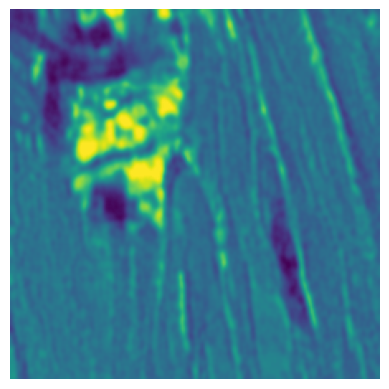

45000


In [7]:
if args.down_res:
    args.down_res = [int(x) for x in args.down_res]
if args.down_prob:
    args.down_prob = [float(x) for x in args.down_prob]

print('job dir:', os.getcwd())
print("{}".format(args).replace(', ', ',\n'))

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
cudnn.benchmark = True

# set up train_transform for augmentation
if args.weak_aug:
    print('using weak augmentation')
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
else:
    print('using strong augmentation')
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.08, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

if args.downsample:
    print('add downsample augmentation')
    train_transform = transforms.Compose([
        transforms.RandomApply([DownSampleAndUpsample(down_res=args.down_res, p=args.down_prob)],
                               p=args.downsample_prob),
        train_transform])

# main_print(('csv path:', args.csv_path))
# main_print(('data folder list:', args.folder_list))
# train_dataset = SupconDataset(
#     input_filename=args.csv_path,
#     root_list=args.folder_list,
#     transforms=train_transform,
#     num_views=args.n_img,
#     num_crop=args.num_crop,
#     tokenizer=args.tokenizer if args.add_language else None,
# )
train_dataset = SSLGenDataset(
    # input_filename=args.csv_path,
    # root_list=args.folder_list,
    root_folder=args.root_folder,
    transforms=train_transform,
    num_views=args.n_img,
    num_crop= 1,
    # tokenizer=args.tokenizer if args.add_language else None,
)
images, _ = train_dataset[3]
plt.imshow(images[7])
plt.axis('off')  # Optional: Turn off axis
plt.show()
print(len(train_dataset))

In [8]:
# misc.init_distributed_mode(args)
train_sampler = None
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.num_workers, pin_memory=args.pin_mem, sampler=train_sampler, drop_last=True)

# global_rank = misc.get_rank()

if args.log_dir is not None:
    os.makedirs(args.log_dir, exist_ok=True)
    log_writer = SummaryWriter(log_dir=args.log_dir)
else:
    log_writer = None
    
model = v_model_dict[args.model](ssl_mlp_dim=args.ssl_mlp_dim, ssl_emb_dim=args.ssl_emb_dim)
criterion = MultiPosConLoss(temperature=args.ssl_temp)

model = model.to(device)
criterion = criterion.to(device)
model_without_ddp = model
if args.lr is None:  # only base_lr is specified
        eff_batch_size = args.batch_size * misc.get_world_size()
        args.lr = args.blr * eff_batch_size * args.n_img / 256
        args.lr = args.lr * args.num_crop / 2  # previous line assumes num_crop=2

print("lr: %.3e" % args.lr)

param_groups = misc.add_weight_decay(model, args.weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(args.beta1, args.beta2))
loss_scaler = NativeScaler()

# resume model if needed
misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

print(f"Start training for {args.epochs} epochs")
start_time = time.time()
for epoch in range(args.start_epoch, args.epochs):
    train_stats = train_one_epoch(
        model, train_loader,
        optimizer, device, epoch, loss_scaler, criterion,
        log_writer=log_writer,
        args=args
    )

    if args.output_dir and (epoch % args.save_freq == 0 or epoch + 1 == args.epochs):
        misc.save_model(
            args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
            loss_scaler=loss_scaler, epoch=epoch, n_keep=args.n_keep)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                 'epoch': epoch, }

    if args.output_dir and misc.is_main_process():
        if log_writer is not None:
            log_writer.flush()
        with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
            f.write(json.dumps(log_stats) + "\n")

    #save the last model
    to_save = {
        'model': model_without_ddp.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'scaler': loss_scaler.state_dict(),
        'args': args,
    }
    checkpoint_path = os.path.join(args.output_dir, 'epoch_last.pth')
    misc.save_on_master(to_save, checkpoint_path)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

lr: 2.344e-05
Start training for 15 epochs
Epoch: [0]  [    0/11250]  eta: 1 day, 3:26:44  lr: 0.000000  loss: 1.3747 (1.3747)  time: 8.7826  data: 0.4148  max mem: 1888
Epoch: [0]  [  100/11250]  eta: 0:31:34  lr: 0.000000  loss: 2.3431 (2.3830)  time: 0.0856  data: 0.0003  max mem: 3138
Epoch: [0]  [  200/11250]  eta: 0:23:16  lr: 0.000000  loss: 2.0138 (2.3370)  time: 0.0838  data: 0.0003  max mem: 3138
Epoch: [0]  [  300/11250]  eta: 0:20:22  lr: 0.000001  loss: 1.8953 (2.2544)  time: 0.0830  data: 0.0003  max mem: 3138
Epoch: [0]  [  400/11250]  eta: 0:18:51  lr: 0.000001  loss: 1.9513 (2.1975)  time: 0.0828  data: 0.0003  max mem: 3138
Epoch: [0]  [  500/11250]  eta: 0:17:53  lr: 0.000001  loss: 1.9394 (2.1601)  time: 0.0836  data: 0.0003  max mem: 3138
Epoch: [0]  [  600/11250]  eta: 0:17:15  lr: 0.000001  loss: 1.5915 (2.1210)  time: 0.0814  data: 0.0004  max mem: 3138
Epoch: [0]  [  700/11250]  eta: 0:16:43  lr: 0.000001  loss: 1.8957 (2.0967)  time: 0.0822  data: 0.0003  max 